In [1]:
!pip install gdown

In [2]:
!gdown 1sm63itCePDOMmDRviM9R7rtVE4BiFvvn

Downloading...
From (original): https://drive.google.com/uc?id=1sm63itCePDOMmDRviM9R7rtVE4BiFvvn
From (redirected): https://drive.google.com/uc?id=1sm63itCePDOMmDRviM9R7rtVE4BiFvvn&confirm=t&uuid=7d04bb1e-83f8-47f1-b9b5-43bf5dc9dc60
To: /content/archive (5).zip
100% 8.77G/8.77G [02:13<00:00, 65.5MB/s]


In [14]:
!unzip "archive (5).zip"

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [18]:
!pip -q install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 59.8 MB/s eta 0:00:00


In [20]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from matplotlib.pyplot import plot
import random

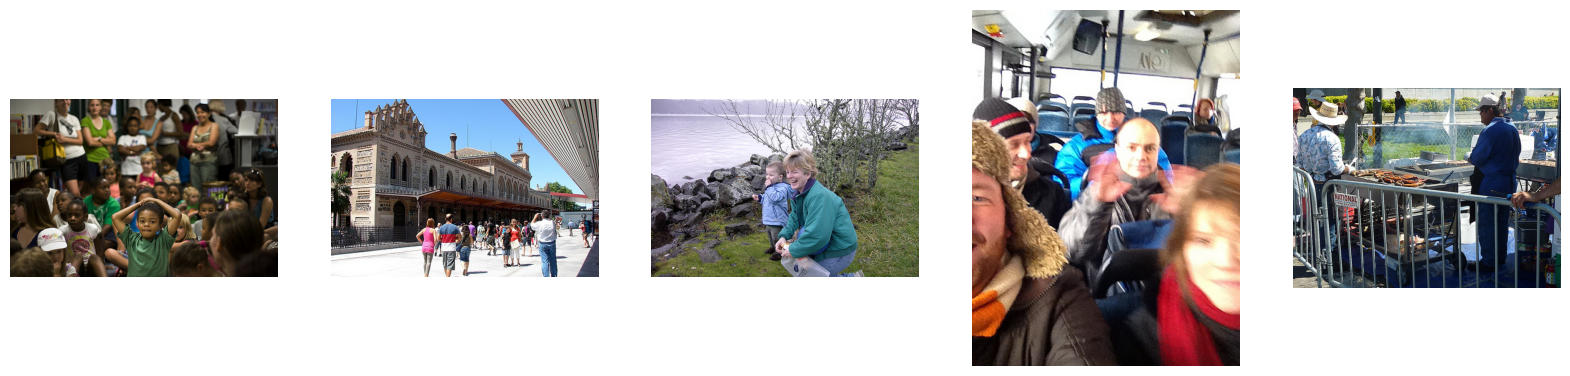

In [24]:
import matplotlib.pyplot as plt

image_folder = "/content/flickr30k_images/flickr30k_images/flickr30k_images"

image_files = glob(os.path.join(image_folder, "*.jpg"))

selected_files = random.sample(image_files, 10)

plt.figure(figsize=(20, 5))

for i, file in enumerate(selected_files[:5]):
    img = Image.open(file)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.show()

In [32]:
# Tạo embedding cho 30K ảnh bằng model
model = SentenceTransformer("clip-ViT-B-32")
image_path = "/content/flickr30k_images/flickr30k_images"

image_files = glob(os.path.join(image_path, "*.jpg"))
chunk_size = 128

embeddings = []

def process_chunk(chunk):
    images = []
    for image_file in chunk:
        images.append(Image.open(image_file))

    chunk_embeddings = model.encode(images)
    return chunk_embeddings

#for image_file in image_files:
    #image = Image.open(image_file)
    #image_embedding = model.encode(image)
    #embeddings.append(image_embedding)

for i in range(0, len(image_files), chunk_size):
    print(i)
    chunk = image_files[i:i + chunk_size]
    embeddings.extend(process_chunk(chunk))

0
128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3072
3200
3328
3456
3584
3712
3840
3968
4096
4224
4352
4480
4608
4736
4864
4992
5120
5248
5376
5504
5632
5760
5888
6016
6144
6272
6400
6528
6656
6784
6912
7040
7168
7296
7424
7552
7680
7808
7936
8064
8192
8320
8448
8576
8704
8832
8960
9088
9216
9344
9472
9600
9728
9856
9984
10112
10240
10368
10496
10624
10752
10880
11008
11136
11264
11392
11520
11648
11776
11904
12032
12160
12288
12416
12544
12672
12800
12928
13056
13184
13312
13440
13568
13696
13824
13952
14080
14208
14336
14464
14592
14720
14848
14976
15104
15232
15360
15488
15616
15744
15872
16000
16128
16256
16384
16512
16640
16768
16896
17024
17152
17280
17408
17536
17664
17792
17920
18048
18176
18304
18432
18560
18688
18816
18944
19072
19200
19328
19456
19584
19712
19840
19968
20096
20224
20352
20480
20608
20736
20864
20992
21120
21248
21376
21504
21632
21760
21888
22016
22144
22272
22400
22528
22656
22784
22912
23040
231

In [33]:
dismension = len(embeddings[0])
index = faiss.IndexFlatIP(dismension)
index = faiss.IndexIDMap(index)

vectors = np.array(embeddings).astype('float32')
index.add_with_ids(vectors, np.array(range(len(embeddings))))

faiss.write_index(index, "index.faiss")

with open("image_files.txt", "w") as f:
  for image_file in image_files:
    f.write(image_file + "\n")

In [34]:
def search_image(query, model, index, image_files, top_k=5):
  if query.endswith(".jpg"):
    query = Image.open(query)

  query_embedding = model.encode(query)
  query_embedding = np.array(query_embedding).astype('float32').reshape(1, -1)

  distances, indices = index.search(query_embedding, top_k)

  retrieved_image_file = [image_files[i] for i in indices[0]]
  return retrieved_image_file



In [35]:
# Visualize retrieved image files
def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):
        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

In [40]:
query = "a dog"
retrieved_image_files = search_image(query, model, index, image_files)

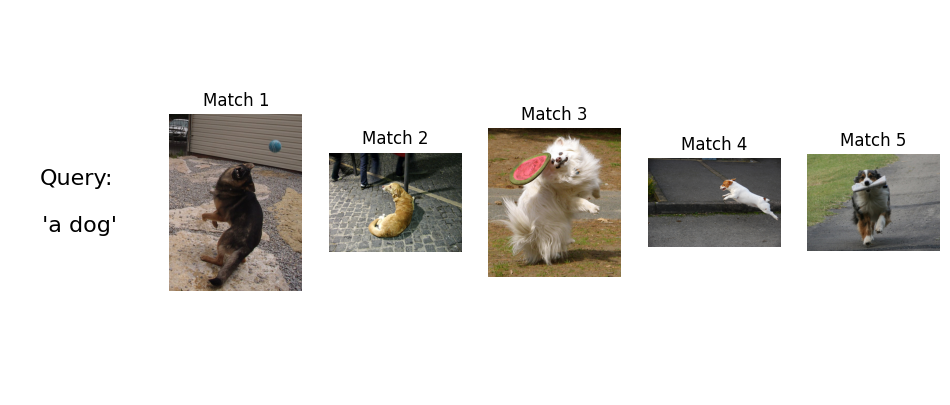

In [41]:
visualize_results(query, retrieved_image_files)

In [39]:
print (retrieved_image_files)

['/content/flickr30k_images/flickr30k_images/662606040.jpg', '/content/flickr30k_images/flickr30k_images/3418504074.jpg', '/content/flickr30k_images/flickr30k_images/661755629.jpg', '/content/flickr30k_images/flickr30k_images/661757041.jpg', '/content/flickr30k_images/flickr30k_images/3081734118.jpg']
